
# Compressive Sensing

This example demonstrates following features
- Adquisition step: Compressive measurements of a sparse signal 
- Recovering step: Recovering the original signal using the IHT (Iterative Hard Thresholding) algorithm.


Let's import necessary libraries 
*   [jax](https://github.com/google/jax): library for high-performance machine learning and numerical computations.
*   [cr-sparse](https://github.com/carnotresearch/cr-sparse): library for sparse signal represesentation with JAX.
* [cr-nimble](https://github.com/carnotresearch/cr-nimble): library for iterative algorithms for numerical linear algebra with JAX.

In [1]:
import jax
from jax import random
import jax.numpy as jnp  # Accelerated numpy library.
from jax.numpy.linalg import norm

import matplotlib as mpl
import matplotlib.pyplot as plt

import cr.nimble as cnb
import cr.sparse as crs
import cr.sparse.dict as crdict
import cr.sparse.data as crdata
import cr.sparse.cs.cs1bit as cs1bit

import time

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


# Setup



In [2]:
# Number of measurements
M = 120
# Ambient dimension
N = 500
# Sparsity level
K = 10

# Sensing Matrix
_Function help_
- [gaussian_mtx()](https://cr-sparse.readthedocs.io/en/latest/source/_autosummary/cr.sparse.dict.gaussian_mtx.html?highlight=gaussian_mtx)


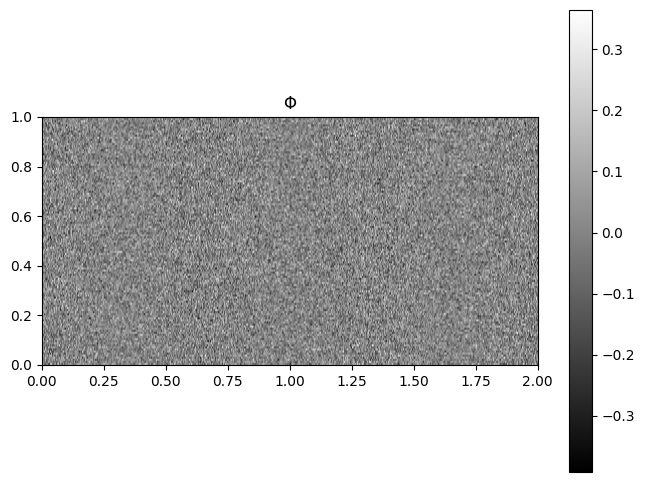

In [3]:
# Sensing matrix
Phi = crdict.gaussian_mtx(cnb.KEYS[0], M, N, normalize_atoms=True) 

# Frame bound (You can ignore this)
s0 = crdict.upper_frame_bound(Phi)  # Computes the upper frame bound for a dictionary. Upper frame bound: https://en.wikipedia.org/wiki/Frame_(linear_algebra)

# Plot sensing matrix
fig=plt.figure(figsize=(8, 6), dpi= 100, facecolor='w', edgecolor='k')
plt.imshow(Phi, extent=[0, 2, 0, 1])
plt.gray()
plt.colorbar()
plt.title(r'$\Phi$');

# K-sparse signal generation
_Function help_
- [sparse_normal_representations()](https://cr-sparse.readthedocs.io/en/latest/source/_autosummary/cr.sparse.data.sparse_normal_representations.html?highlight=sparse_normal_representations): Generates a set of sparse model vectors with normally distributed non-zero entries.



omega = [164 199 238 265 298 317 349 396 459 493]


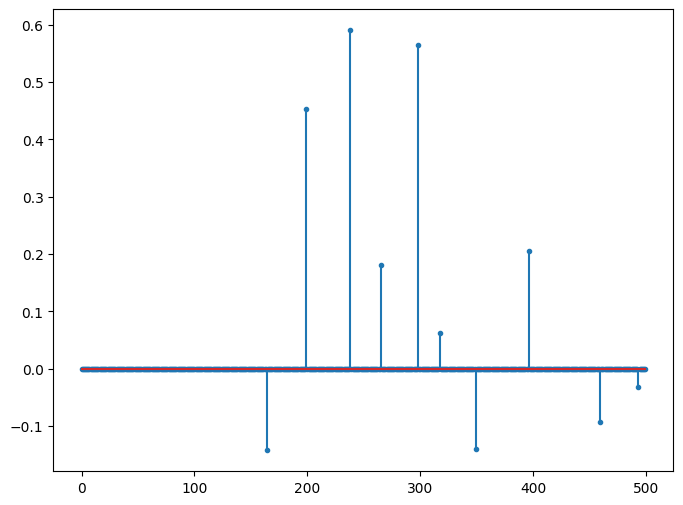

In [4]:
# Generation of a random sparse vector.
x, omega = crdata.sparse_normal_representations(cnb.KEYS[1], N, K)

# Normalize signal
x = x / norm(x)

# The support indices
print(f"omega = {omega}")

# Plot sparse signal
fig=plt.figure(figsize=(8, 6), dpi= 100, facecolor='w', edgecolor='k')
plt.stem(x, markerfmt='.');

# Measurement process or acquisition step
Compressive measurements

Norm of noise: 1.0000e-01
Elapse time: 1.7484e-02 seconds


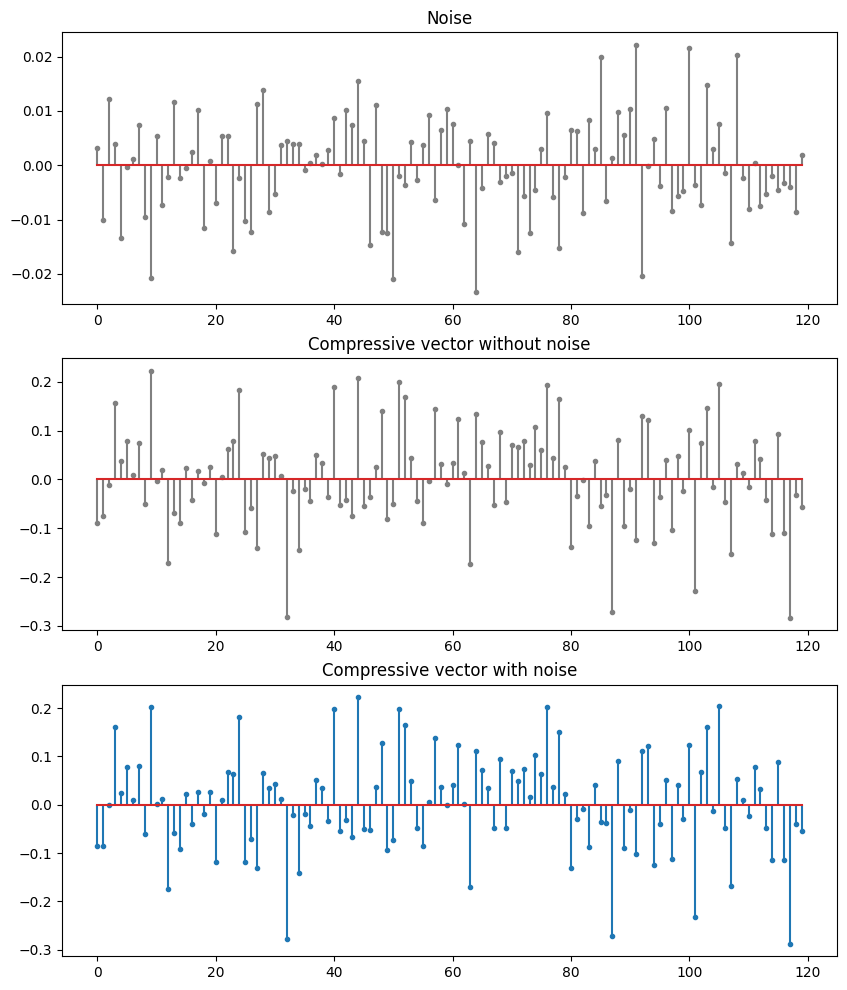

In [5]:
# Key for pseudo-random number generation
key = random.PRNGKey(0)

# Noise
noise = jax.random.normal(key, shape=(M,))
noise = noise / norm(noise) / 10
print(f"Norm of noise: {norm(noise):.4e}")

# Matrix multiplication
start = time.time()
y0 = Phi @ x
y = y0 + noise # -> Add noise
end = time.time()
print(f'Elapse time: {end - start:.4e} seconds')

# Plot compressive vector with and without noise
fig=plt.figure(figsize=(10, 12), dpi= 100, facecolor='w', edgecolor='k')
plt.subplot(311)
plt.title('Noise')
plt.stem(noise, markerfmt='.', linefmt='gray');
plt.subplot(312)
plt.title('Compressive vector without noise')
plt.stem(y0, markerfmt='.', linefmt='gray');
plt.subplot(313)
plt.stem(y, markerfmt='.');
plt.title('Compressive vector with noise');

# Signal Reconstruction/Recovering using IHT (Iterative Hard Thresholding)

### IHT (Iterative Hard Thresholding)
- See [Greedy Sparse Recovery](https://carnotresearch.github.io/cr-sparse/source/pursuit.html)

In [6]:
from cr.sparse.pursuit import iht
sol = iht.matrix_solve_jit(Phi, y, K, normalized=True, step_size=None, max_iters=None, res_norm_rtol=0.0001)
x_rec = cnb.dsp.build_signal_from_indices_and_values(N, sol.I, sol.x_I)

I = [164 199 238 265 298 317 349 396 459 493]


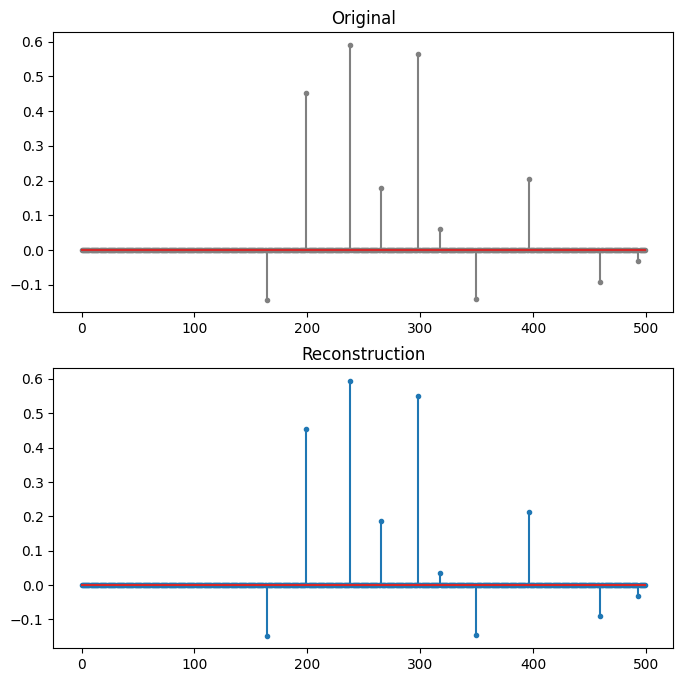

In [7]:
# Plot original and reconstructed signals
fig=plt.figure(figsize=(8, 8), dpi= 100, facecolor='w', edgecolor='k')
plt.subplot(211)
plt.title('Original')
plt.stem(x, markerfmt='.', linefmt='gray');
plt.subplot(212)
plt.stem(x_rec, markerfmt='.');
plt.title('Reconstruction')

# Recovered support
I = jnp.sort(sol.I)
print(f"I = {I}")

#### Verification

In [8]:
# Check if correctly recovered
print(f'Support correctly recovered?: {jnp.array_equal(omega, I)}')

# The norm of error
print(f'Error: {norm(x - x_rec):.4e}')

Support correctly recovered?: True
Error: 3.2980e-02
